In [6]:
import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
from torch.nn import Sequential as Seq, Linear as Lin, ReLU
import numpy as np
import torch.nn.functional as F
import pickle
from data import *
from util import *
from model import *
from loss_functions import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using {}".format(device))

Using cpu


In [7]:
def plot_single_pred(logits, tri, b, step):
    '''
    plot the model's prediction of prob as well as the truth label as histogram

    Arguments:
        logits: (max_len, B, N+1) predicted logits
        tri: (B, max_steps, 3) truth reference 
        b: int, indices of data point in the batch to plot
        step: int, the number of step to plot
    '''
    probs = torch.softmax(logits, dim=-1)
    heights = probs[:, b, :][step].detach().numpy()
    x = np.arange(len(heights))
    
    truth = tri[b][step].detach().to(torch.int64).numpy()
    
    # Default all bars to blue
    colors = ['blue'] * len(heights)
    
    # Color the "truth" indices red
    for idx in truth:
        colors[idx] = 'red'
    plt.figure(figsize=(6, 1.5));
    plt.bar(x, heights, color=colors);
    plt.ylabel("Prob");
    plt.title("Model's Prediction in b={}, step={}".format(b, step));
        

In [8]:
#train set
data = np.load("dataset_xytri_10000_ordered_random.npz")
X_loaded = torch.Tensor(data["X"]).to(device) #shape N, 20, 2 N = 10000
Y_loaded = torch.Tensor(data["Y"]).to(device) #shape N, 20, 20
tri_loaded = torch.Tensor(data["tri"]).to(device)

train_dataset = GraphDataSet(X_loaded, Y_loaded, tri_loaded)
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

#test set
data_test = np.load("testset_xytri_2000_ordered.npz")
X_test = torch.Tensor(data_test["X"]).to(device) #shape N, 20, 2 N = 10000
Y_test = torch.Tensor(data_test["Y"]).to(device) #shape N, 20, 20
tri_test = torch.Tensor(data_test["tri"]).to(device)

test_dataset = GraphDataSet(X_test, Y_test, tri_test)
batch_size = 256
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [9]:
##load the model 
model8 = GraphPointerNet(2, 4, embedding_dim = 32, num_layers=5, hidden_dim=256, max_steps=40, attention=True).to(device)
model8.load_state_dict(torch.load('model8.pt'));
model8.to(device);

In [10]:
for x, y, tri in train_loader:
    break
    
data_batch = make_pyg_batch_wedge(x, 5)

import time
s = time.time()
logits, indicies = model8(data_batch, max_steps=50, teacher_indices=tri)
e = time.time()
print("Time used to build {} Delaunay graph is: {}".format(batch_size, e-s))
print("Each graph takes: ", (e-s)/batch_size)

Time used to build 256 Delaunay graph is: 0.8330178260803223
Each graph takes:  0.003253975883126259


/var/folders/tj/wvvkfdg54p3dcmb4w30nzjc00000gn/T/ipykernel_63320/3570057413.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 1.5));


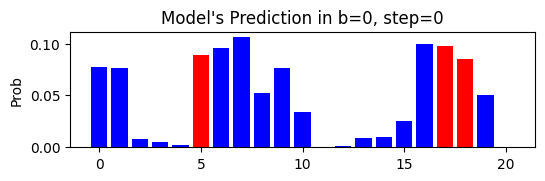

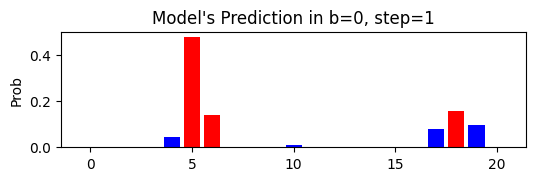

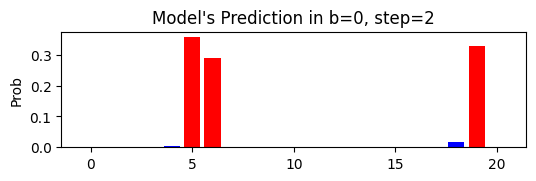

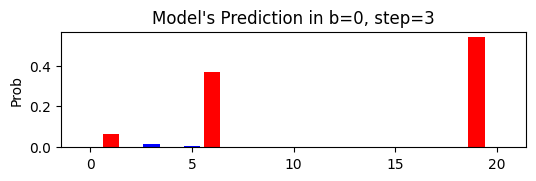

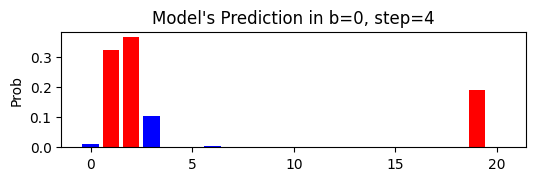

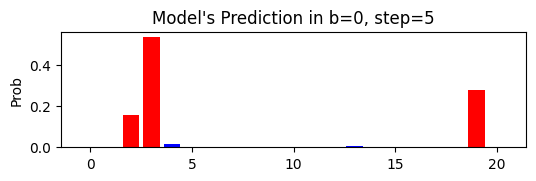

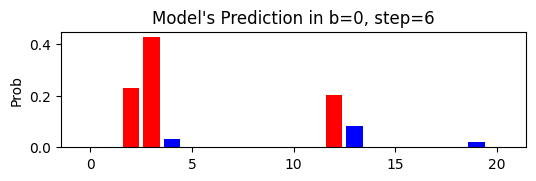

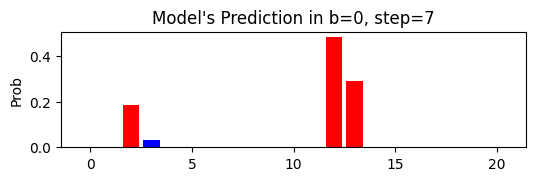

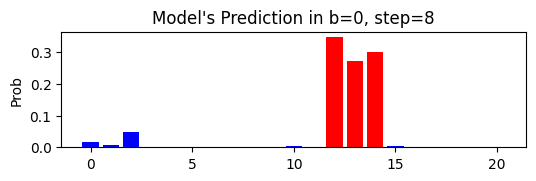

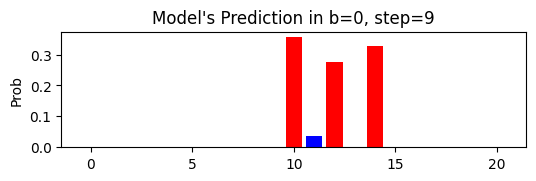

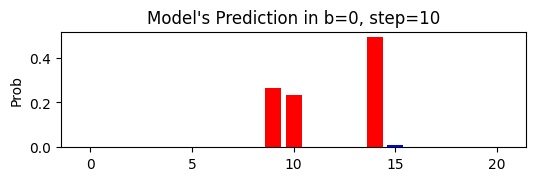

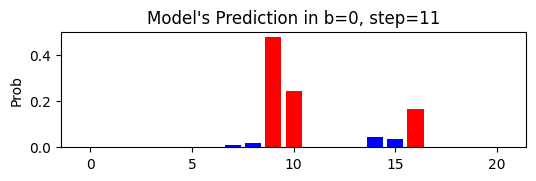

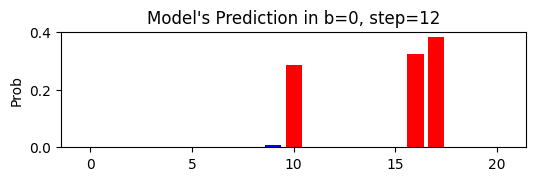

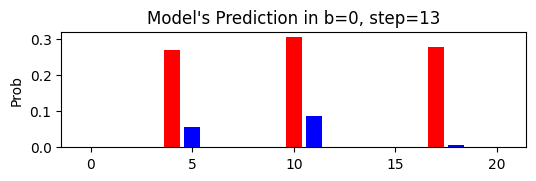

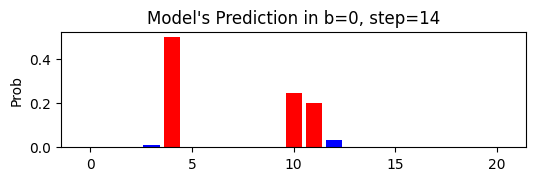

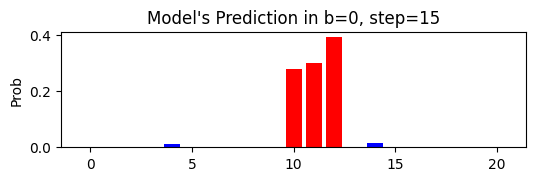

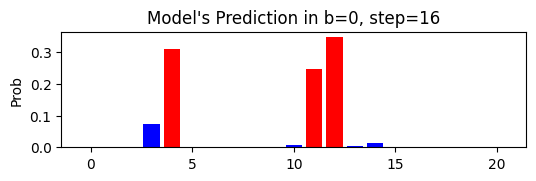

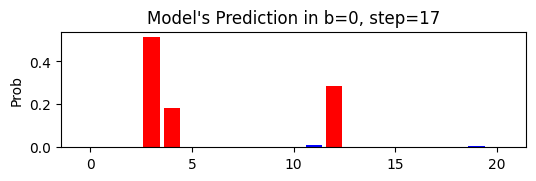

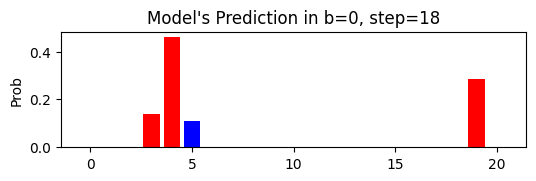

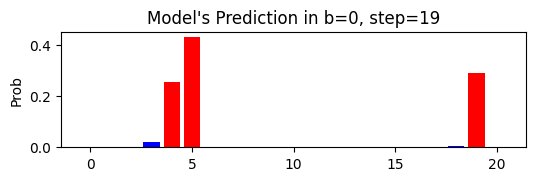

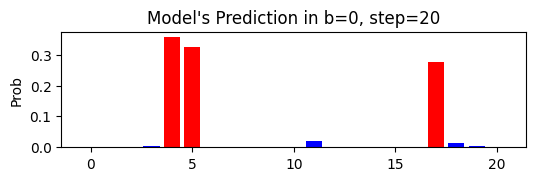

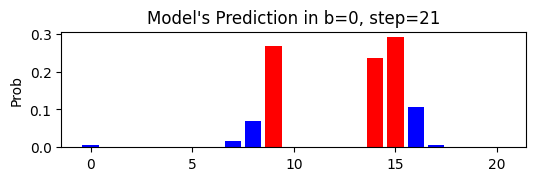

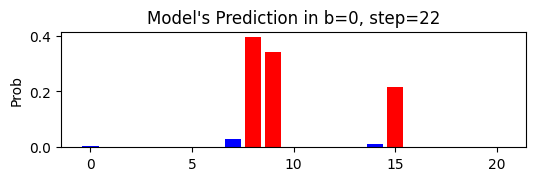

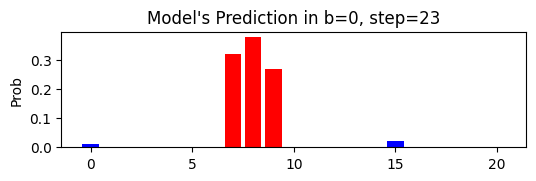

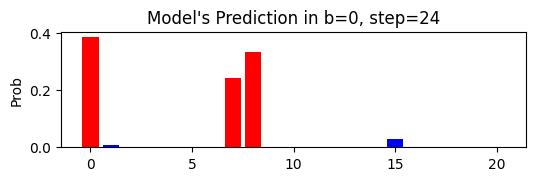

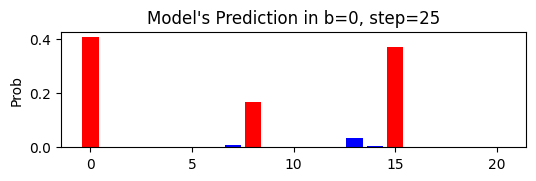

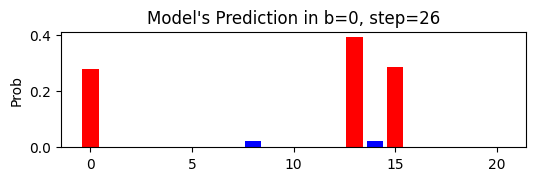

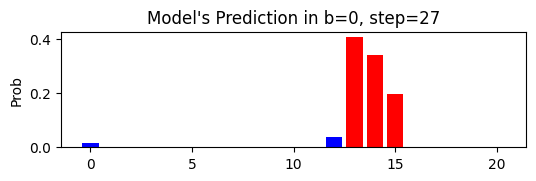

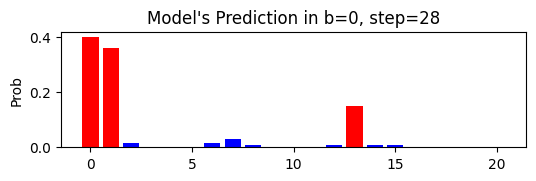

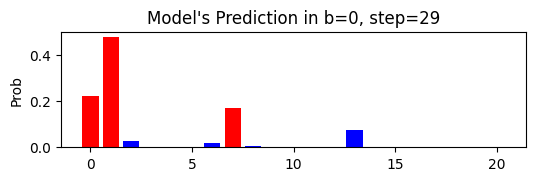

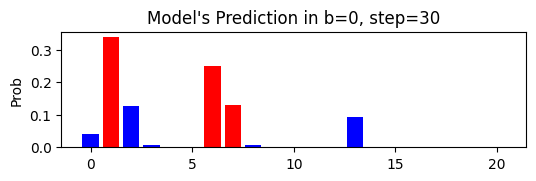

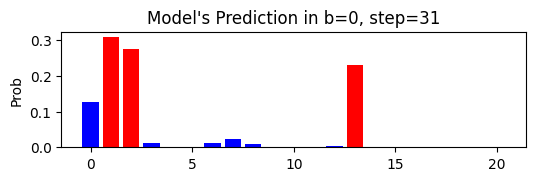

In [11]:
for step in range(32):
    plot_single_pred(logits, tri, 0, step)

In [174]:
##evaluate the model using IOU on train set
iou_list = []
for x, y, tri in tqdm(train_loader):
    data_batch = make_pyg_batch_wedge(x, 5)
    logits, indicies = model8(data_batch, max_steps=50)
    iou_list.append(iou_triangles(tri, indicies))
print("Average IOU w/o teacher forcing: ", sum(iou_list)/len(iou_list))

  0%|          | 0/303 [00:00<?, ?it/s]

Average IOU w/o teacher forcing:  0.6785309324563533


In [13]:
##evaluate the model using IOU on test set
iou_list = []
for x, y, tri in tqdm(test_loader):
    data_batch = make_pyg_batch_wedge(x, 5)
    logits, indicies = model8(data_batch, max_steps=50)
    iou_list.append(iou_triangles(tri, indicies))
print("Average IOU w/o teacher forcing: ", sum(iou_list)/len(iou_list))

  0%|          | 0/8 [00:00<?, ?it/s]

Average IOU w/o teacher forcing:  0.6720860749483109


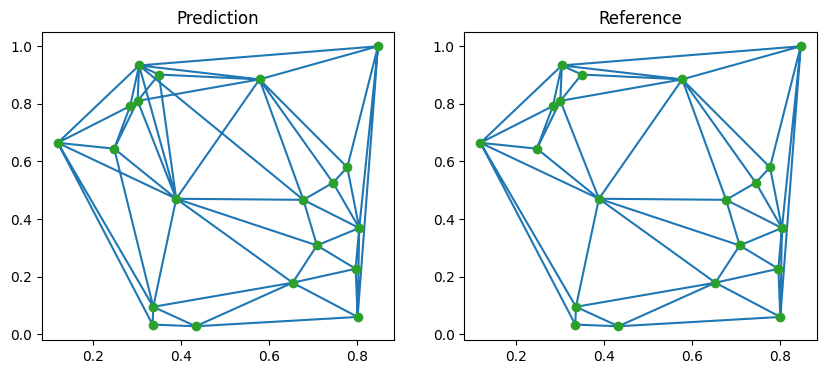

In [75]:
i = 16

test_point = x[i].numpy()
test_tri = indicies[:, i, :].numpy()[(indicies[:, i, :].numpy() != 20).all(axis=1)]

mask = (tri[i].numpy() != 20).all(axis=1) * (tri[i].numpy() != -1).all(axis=1)
reference_tri = tri[i].numpy()[mask]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].triplot(test_point[:,0], test_point[:,1], test_tri)
ax[0].plot(test_point[:,0], test_point[:,1], 'o');
ax[0].set_title("Prediction");

ax[1].triplot(test_point[:,0], test_point[:,1], reference_tri)
ax[1].plot(test_point[:,0], test_point[:,1], 'o');
ax[1].set_title("Reference");

In [244]:
print(len(test_tri))
print(len(reference_tri))

32
30


In [100]:
#mistakes are more likely to make either
#1. at the begining, where the model has insufficient info and predicts almost random triangles
#2. in the end, the model predicts more triangles. The stop sign should be predicted earlier. After all correct triangles are predicted
#the model predicts garbage
#3. The model is unaware of creating a convex hull from the points (which makes sense because we never enforce it)

In [38]:
##use a different order to traverse the input sequence of nodes because
##DFS delaunay order creates leackage problem
##should do DFS or BFS on KNN graph. 

In [164]:
##evaluate the model using IOU on new test set
# data_test = np.load("testset_xytri_2000_N10_ordered_random.npz")
# X_test = torch.Tensor(data_test["X"]).to(device) #shape N, 20, 2 N = 10000
# Y_test = torch.Tensor(data_test["Y"]).to(device) #shape N, 20, 20
# tri_test = torch.Tensor(data_test["tri"]).to(device)

# test_dataset = GraphDataSet(X_test, Y_test, tri_test)
# batch_size = 256
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# iou_list = []
# for x, y, tri in tqdm(test_loader):
#     data_batch = make_pyg_batch_wedge(x, 5)
#     logits, indicies = model8(data_batch, max_steps=20)
#     iou_list.append(iou_triangles(tri, indicies))
# print("Average IOU w/o teacher forcing: ", sum(iou_list)/len(iou_list))